In [1]:
# Standard library imports
from copy import deepcopy
from io import BytesIO

# Third-party imports
import requests
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.io import fits
from astropy.visualization import make_lupton_rgb
from astropy.io import fits
import pandas as pd
from matplotlib.path import Path
import os
from astropy.wcs import WCS
from astropy import units as u
from astropy.coordinates import SkyCoord
from shapely.geometry import Polygon
from astropy.visualization import SqrtStretch,LogStretch
from astropy.visualization import ZScaleInterval
from reproject import reproject_interp
from astropy.visualization import make_lupton_rgb
from matplotlib.patches import Ellipse
from scipy import stats

# Project import
import artpop

# artpop's matplotlib style
plt.style.use(artpop.mpl_style)

# use this random state for reproducibility
rng = np.random.RandomState(100)

In [2]:
#upload VISTA data
from functions import load_fits,vmc_filenames,implot,image_bounds,rotated_ellipse,inside_shape,color3,circle,visualize_shape

test=ZScaleInterval()
stretch = SqrtStretch() + ZScaleInterval()

names = vmc_filenames('3_8')

hdu,headers = {},{}

for name in names:
    
    band,hdu1,header1=load_fits(name,extension=1)
    
    hdu[band]=hdu1
    headers[band]=header1

vmin,vmax = test.get_limits(hdu['Ks'].data)

This is band J
This is band Y
This is band Ks


In [3]:
print(headers['Ks']['MAGZPT'])
print(headers['J']['MAGZPT'])
print(headers['Y']['MAGZPT'])

22.8254
23.6011
23.3143


In [4]:
print(headers['Ks']['TEXPTIME'])
print(headers['J']['TEXPTIME'])
print(headers['Y']['TEXPTIME'])

9000.0
2400.0
2800.0


In [5]:
from artpop.stars._read_mist_models import IsoCmdReader

def read_iso(phot_system, mist_path, log_age, feh, v_over_vcrit=0.4):
    v = f'{v_over_vcrit:.1f}'
    ver = 'v1.2'
    path = os.path.join(mist_path, 'vista/MIST_' + ver + f'_vvcrit{v}_' + phot_system)
    sign = 'm' if feh < 0 else 'p'
    fn = f'MIST_{ver}_feh_{sign}{abs(feh):.2f}_afe_p0.0_vvcrit{v}_{phot_system}.iso.cmd'
    fn = os.path.join(path, fn)
    iso_cmd = IsoCmdReader(fn, verbose=False)
    iso_cmd = iso_cmd.isocmds[iso_cmd.age_index(log_age)]
    return iso_cmd

#input log_age =6, feh = -1
iso = read_iso("VISTA", ".", 10, -1.5)

bands = [b for b in iso.dtype.names if b[:5] == "VISTA"]

iso = artpop.Isochrone(
    mini=iso["initial_mass"], 
    mact=iso["star_mass"], 
    mags=iso[bands], 
    eep=iso["EEP"], 
    log_L=iso["log_L"],
    log_Teff=iso["log_Teff"]
)

In [6]:
ramin,ramax,decmin,decmax,limits = image_bounds(hdu['Ks'].data,WCS(headers['Ks']))

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


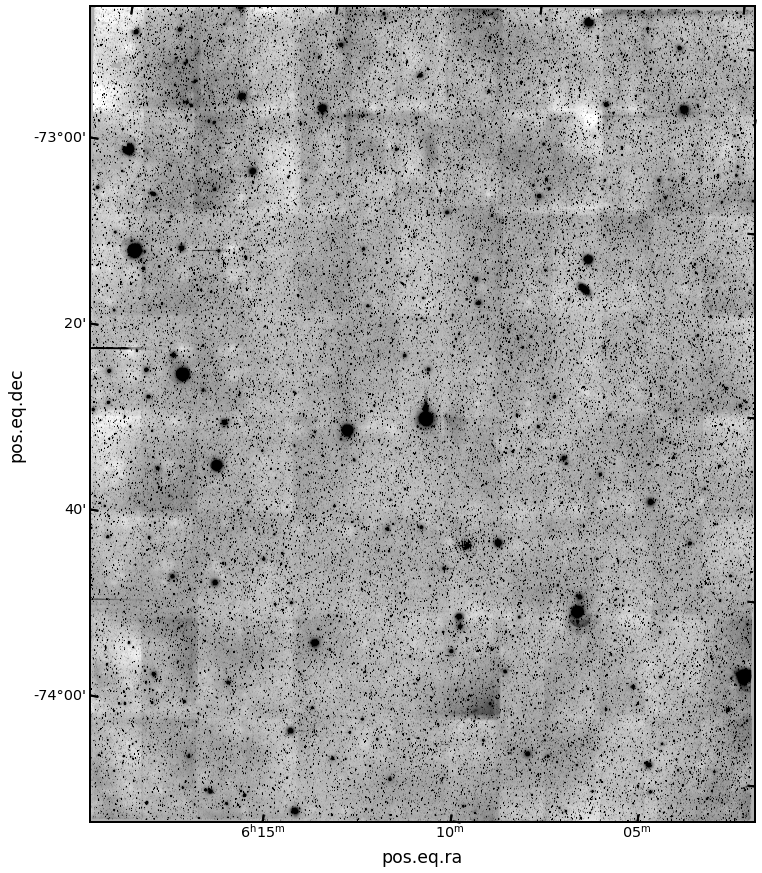

In [7]:
#plot vista ks image
vmin3,vmax3 = test.get_limits(hdu['Ks'].data)
plt.figure(figsize=(20,15))
ax3=plt.subplot(projection=WCS(headers['Ks']))
vmin3,vmax3 = test.get_limits(hdu['Ks'].data)
im = ax3.imshow(hdu['Ks'].data,origin='lower',cmap='gray_r',vmin=vmin3,vmax=vmax3)
ax3.invert_yaxis()


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


(2389, 2421)


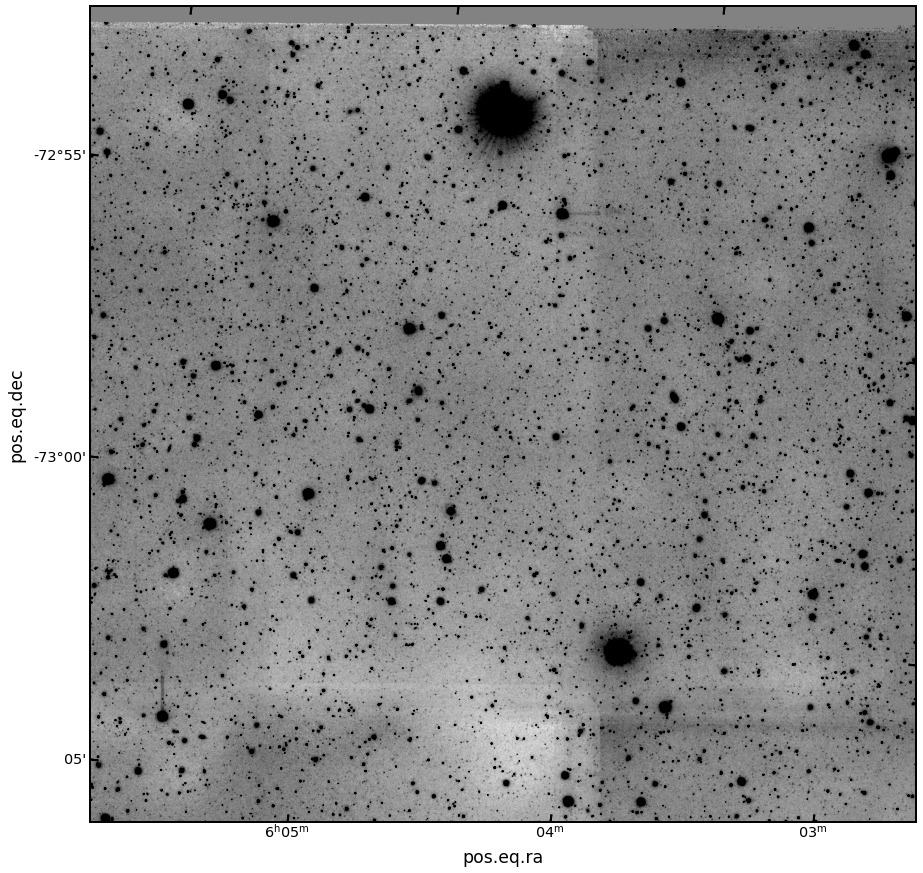

In [8]:
#plot cutout of vista ks image

ra1=91
dec1=-73
rad1=100/871
data=hdu['Ks'].data
wcs=WCS(headers['Ks'])
xx5,yy5 = circle(ra1,dec1,rad1,1)

s,total3,limits3=inside_shape(xx5,yy5,data,wcs,pix=False)
xmin3,xmax3,ymin3,ymax3 = limits3
cutout3 = data[int(ymin3):int(ymax3),int(xmin3):int(xmax3)]
print(cutout3.shape)

vmin3,vmax3 = test.get_limits(cutout3)
plt.figure(figsize=(20,15))
ax3=plt.subplot(projection=wcs[int(ymin3):int(ymax3),int(xmin3):int(xmax3)])
vmin3,vmax3 = test.get_limits(cutout3)
im = ax3.imshow(cutout3,origin='lower',cmap='gray_r',vmin=vmin3,vmax=vmax3)
ax3.invert_yaxis()


In [10]:
zpt = headers["Ks"]['MAGZPT']
pixel_scale = 0.34

In [11]:
mof_psf = artpop.moffat_psf(fwhm=1,pixel_scale=pixel_scale)


In [21]:

ssp = artpop.SSP(iso, num_stars=10e6, distance=50*u.kpc)
#sersic spatial distribution
source = artpop.SersicSP(
    sp=ssp,
    n=0.8,
    r_eff=5*u.pc,
    theta=45 * u.deg, 
    ellip=0.3, 
    #pixel size xy
    xy_dim=701, 
    pixel_scale=pixel_scale,

)

In [22]:
filter_obj = artpop.filters.FilterSystem(filter_curve_files=['VISTA_J.csv','VISTA_Y.csv','VISTA_Ks.csv'],filter_names=['VISTA_J','VISTA_Y','VISTA_Ks'],delimiter=',',skiprows=1)

zpt_dict = {}
zpt_dict["VISTA_J"]=headers["J"]['MAGZPT']
zpt_dict["VISTA_Y"]=headers["Y"]['MAGZPT']
zpt_dict["VISTA_Ks"]=headers["Ks"]['MAGZPT']

# instantiate an imager object
imager = artpop.ArtImager(
    diameter = 4.1 * u.m, 
    filter_system=filter_obj,
    zpt_inst=zpt_dict
)

In [23]:
obs_ks = imager.observe(
    source = source,         # source object
    bandpass = 'VISTA_Ks',  # bandpass of observation
    exptime = 9000 * u.second, # exposure time
    psf = mof_psf,             # point spread function
)

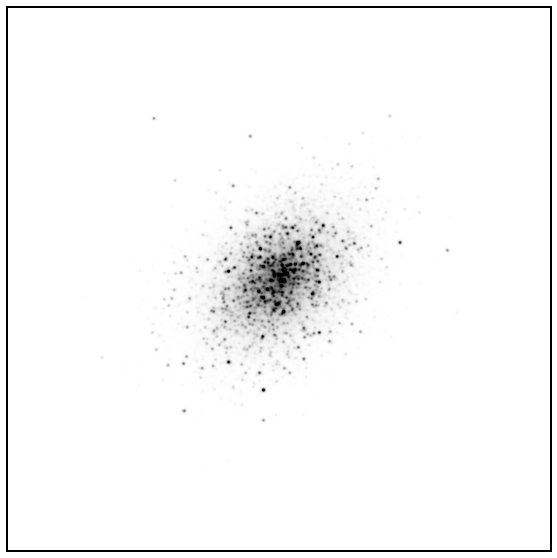

In [24]:
artpop.show_image(obs_ks.image);

In [27]:
#statistics of artifical star cluster
print(np.min(obs_ks.image))
print(np.max(obs_ks.image))
print(np.median(obs_ks.image))
print(np.mean(obs_ks.image))

0.0
289020.5124412342
0.11429314185217122
1104.7889033885274


In [29]:
#statistics of VISTA ks cutout
print(np.min(cutout3))
print(np.max(cutout3))
print(np.median(cutout3))
print(np.mean(cutout3))

1163.7965021603422
32273.607470376865
9266.971221557407
9269.554728934225


In [30]:
# work on deep copy in case we want to make adjustments
mock_image = deepcopy(cutout3)

In [31]:
# get slices to inject young source at (600, 700)
img_slice, arr_slice = artpop.util.embed_slices((600, 700),
                                                obs_ks.image.shape,
                                                cutout3.shape)

In [32]:
# inject young source into image

mock_image[img_slice] += obs_ks.image[arr_slice]

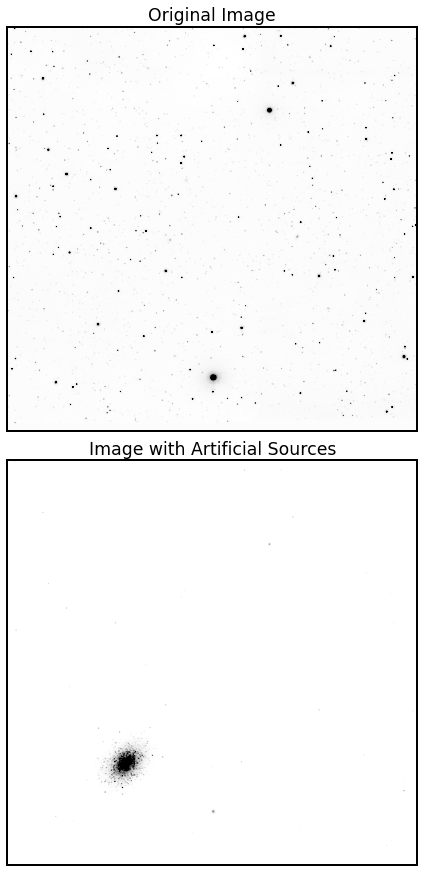

In [33]:
fig, ax = plt.subplots(2, 1, figsize=(12, 12),
                       constrained_layout=True,
                       subplot_kw=dict(xticks=[], yticks=[], aspect='equal'))


ax[0].set_title('Original Image')
artpop.show_image(cutout3, subplots=(fig, ax[0]));

ax[1].set_title('Image with Artificial Sources')

artpop.show_image(mock_image, subplots=(fig, ax[1]));

In [107]:
print(np.min(cutout3))
print(np.max(cutout3))
print(np.median(cutout3))

1163.7965021603422
32273.607470376865
9266.971221557407
